# Data Augmentation

In [17]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [31]:
ALL = False

## $I/$ Access to Dataset

In [32]:
from config import *
import os
import numpy as np

In [41]:
individuals = os.listdir(DATASET_PATH)
if not ALL:
    individuals = [np.random.choice(individuals)]

print(len(individuals), ' individuals')
if not ALL:
    print(individuals)

1  individuals
['F032']


In [42]:
files = []
for individual in individuals:
    files += os.listdir(DATASET_PATH + individual)

print(len(files), ' files')
if not ALL:
    print(files)

5  files
['F032_2019 ©S.Louisy 190612 IMG_4295.JPG', 'F032_2019 ©S.Louisy 190612 IMG_4296.JPG', 'F032_2019 ©S.Louisy 190612 IMG_4297.JPG', 'F032_2019 ©S.Louisy 190612 IMG_4298.JPG', 'F032_crop_csv.csv']


In [43]:
csvs = []
pictures = []
for file in files:
    csvs.append(file) if file.split('.')[-1] == 'csv' else pictures.append(file)

if len(csvs) != len(individuals):
    print('Mismatch between number of individuals and number of csv')

print(len(csvs), ' csv')
if not ALL:
    print(csvs)
print(len(pictures), 'pictures')
if not ALL:
    print(pictures)

1  csv
['F032_crop_csv.csv']
4 pictures
['F032_2019 ©S.Louisy 190612 IMG_4295.JPG', 'F032_2019 ©S.Louisy 190612 IMG_4296.JPG', 'F032_2019 ©S.Louisy 190612 IMG_4297.JPG', 'F032_2019 ©S.Louisy 190612 IMG_4298.JPG']


## $II/$ Resize and Padding

In [3]:
import json
import pandas as pd
import imageio
import imgaug as ia
from imgaug import augmenters as iaa 
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage

from config import *

In [4]:
df = pd.read_csv(path + "F001_crop_csv.csv")
df.head()

,filename,file_size,file_attributes,region_count,region_id,region_shape_attributes,region_attributes
0,F001_2018 ©P_Louisy 180517 PLT_9448.jpg,3325580,{},1,0,"{""name"":""rect"",""x"":1877,""y"":719,""width"":977,""h...",{}
1,F001_2018 ©P_Louisy 180517 PLT_9449.jpg,3522727,{},1,0,"{""name"":""rect"",""x"":2523,""y"":1389,""width"":645,""...",{}
2,F001_2018 ©P_Louisy 180517 PLT_9450.jpg,3234163,{},1,0,"{""name"":""rect"",""x"":1936,""y"":1089,""width"":1151,...",{}
3,F001_2018 ©P_Louisy 180517 PLT_9451.jpg,2997263,{},1,0,"{""name"":""rect"",""x"":1699,""y"":481,""width"":973,""h...",{}
4,F001_2018 ©P_Louisy 180517 PLT_9452.jpg,3031495,{},1,0,"{""name"":""rect"",""x"":1832,""y"":530,""width"":883,""h...",{}


In [5]:
data = df.loc[0]
print(data)

filename                             F001_2018 ©P_Louisy 180517 PLT_9448.jpg
file_size                                                            3325580
file_attributes                                                           {}
region_count                                                               1
region_id                                                                  0
region_shape_attributes    {"name":"rect","x":1877,"y":719,"width":977,"h...
region_attributes                                                         {}
Name: 0, dtype: object


In [6]:
image = imageio.imread(path + data["filename"])

box_data = json.loads(data["region_shape_attributes"])
x = box_data["x"]
y = box_data["y"]
width = box_data["width"]
height = box_data["height"]

bbs = BoundingBoxesOnImage([
    BoundingBox(x, y, x + width, y + height)
], shape=image.shape)


(2848, 4288, 3)
(276, 416, 3)
(416, 416, 3)
(277, 416, 3)
(2855, 4288, 3)

BoundingBoxesOnImage([BoundingBox(x1=1877.0000, y1=719.0000, x2=2854.0000, y2=1469.0000, label=None)], shape=(2848, 4288, 3))
BoundingBoxesOnImage([BoundingBox(x1=182.0970, y1=69.6784, x2=276.8806, y2=142.3609, label=None)], shape=(276, 416, 3))
BoundingBoxesOnImage([BoundingBox(x1=182.0970, y1=69.6784, x2=276.8806, y2=142.3609, label=None)], shape=(416, 416, 3))
BoundingBoxesOnImage([BoundingBox(x1=182.0970, y1=69.6784, x2=276.8806, y2=142.3609, label=None)], shape=(277, 416, 3))
BoundingBoxesOnImage([BoundingBox(x1=1877.0000, y1=718.1651, x2=2854.0002, y2=1467.2942, label=None)], shape=(2855, 4288, 3))



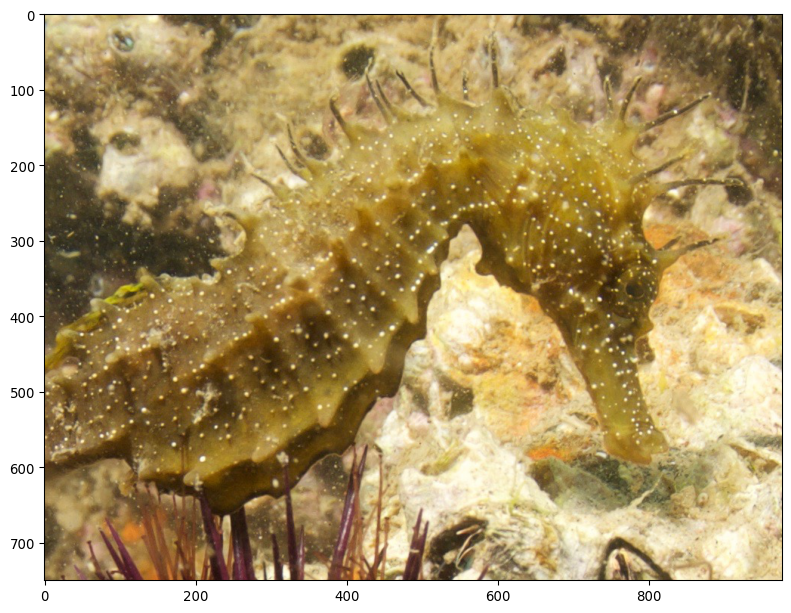

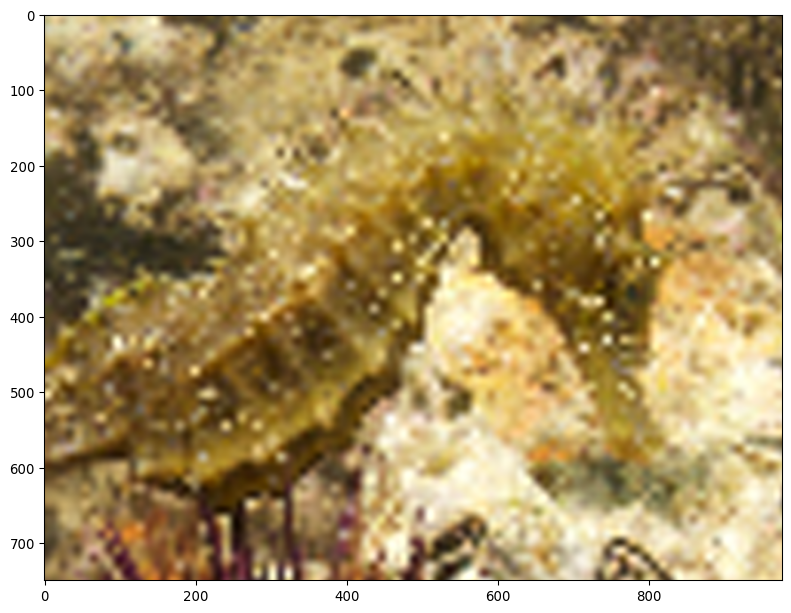

In [18]:
longer_side = max(image.shape)
aspect_ratio = image.shape[1]/image.shape[0]

resize = iaa.Resize({"longer-side": 416, "shorter-side": "keep-aspect-ratio"})
padding = iaa.PadToSquare(pad_mode="constant", pad_cval=0, position="left-bottom")
crop = iaa.CropToAspectRatio(aspect_ratio=aspect_ratio, position='left-bottom')
reverse = iaa.Resize({"longer-side": longer_side, "shorter-side": "keep-aspect-ratio"})

image_resize, bbs_resize = resize(image=image, bounding_boxes=bbs)
image_padding, bbs_padding = padding(image=image_resize, bounding_boxes=bbs_resize)
image_crop, bbs_crop = crop(image=image_padding, bounding_boxes=bbs_padding)
image_reverse, bbs_reverse = reverse(image=image_crop, bounding_boxes=bbs_crop)

# bbs_reverse = bbs_padding.on(image)
bbs_test = bbs_padding.deepcopy()
bbs_test.shape = image_resize.shape

print(image.shape)
print(image_resize.shape)
print(image_padding.shape)
print(image_crop.shape)
print(image_reverse.shape)

print()

print(bbs)
print(bbs_resize)
print(bbs_padding)
print(bbs_crop)
print(bbs_reverse)

print()

ia.imshow(bbs[0].extract_from_image(image))
ia.imshow(bbs_reverse[0].extract_from_image(image_reverse))